In [104]:
import numpy as np
import pandas as pd

from scipy import stats

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from mpl_axes_aligner import align

In [3]:
data_path = 'csv_data/'
THREE_K = '_3k'
TWENTY_K = '_20k'
HUNDRED_K = '_100k'

In [4]:
size = HUNDRED_K

In [5]:
track_df = pd.read_csv(data_path + 'track_df' + size + '.csv').drop(columns=['Unnamed: 0'])
playlist_df = pd.read_csv(data_path + 'playlist_df' + size + '.csv', index_col=0)

In [6]:
most_common_tracks_uri = pd.Series(track_df.groupby(['track_uri']).size().sort_values()[::-1][:50].index)
most_common_tracks_name = track_df[track_df['track_uri'].isin(most_common_tracks_uri)].drop_duplicates(subset=['track_uri'])['track_name']

In [7]:
track_df['in_common'] = track_df['track_uri'].apply(lambda x: x in set(most_common_tracks_uri))

In [8]:
playlist_df = playlist_df.merge(track_df.groupby('pid').sum()['in_common'], on='pid')

In [9]:
playlist_df['name'] = playlist_df['name'].astype('str')
playlist_df['name_len'] = playlist_df['name'].apply(lambda x: len(x))

In [10]:
common_df = playlist_df[playlist_df['in_common'] >= 3]
non_common_df = playlist_df[playlist_df['in_common'] < 3]

common_artists_nums = common_df.groupby('num_artists').size()
non_common_artists_nums = non_common_df.sample(n=len(common_df)).groupby('num_artists').size()

In [11]:
def calc_beta_pdf_values(a, b, step):
    x = np.arange(0, 1, step)
    y = stats.beta.pdf(x, a, b)
    return x, y

In [12]:
def place_axis(ax, x_pos='bottom', y_pos='left'):
    if x_pos == 'top':
        ax.xaxis.tick_top()
    elif x_pos == 'bottom':
        ax.xaxis.tick_bottom()

    if y_pos == 'right':
        ax.yaxis.tick_right()
    elif y_pos == 'left':
        ax.yaxis.tick_left()
        
    ax.xaxis.set_label_position(x_pos) 
    ax.yaxis.set_label_position(y_pos) 

In [57]:
def draw_nums(x, y, ax, color,  x_pos='bottom', y_pos='left'):
    ax.bar(x, y, width=1, color=color)
    
    place_axis(ax, x_pos, y_pos)
    ax.set_xlabel("", color=color, size=14) 
    ax.set_ylabel("", color=color, size=14) 
    ax.tick_params(axis='x', colors=color, labelsize=12)
    ax.tick_params(axis='y', colors=color, labelsize=12) 

In [107]:
def draw_beta_dist(x, y, ax, color,  x_pos, y_pos):
    ax.plot(x, y, color=color)
    ax.fill_between(x, y, color=color, alpha=0.15)
    
    place_axis(ax, x_pos, y_pos)
    ax.set_xlabel("") 
    ax.set_ylabel("")       
    ax.tick_params(axis='x', colors=color, labelsize=12)
    ax.tick_params(axis='y', colors=color, labelsize=12) 

In [119]:
def add_info_box(ax, text, x_pos, y_pos):
    props = dict(boxstyle='round', facecolor='#191414', alpha=0.2)
    ax.text(x_pos, y_pos, text, fontsize=14, transform=ax.transAxes, verticalalignment='top', bbox=props)

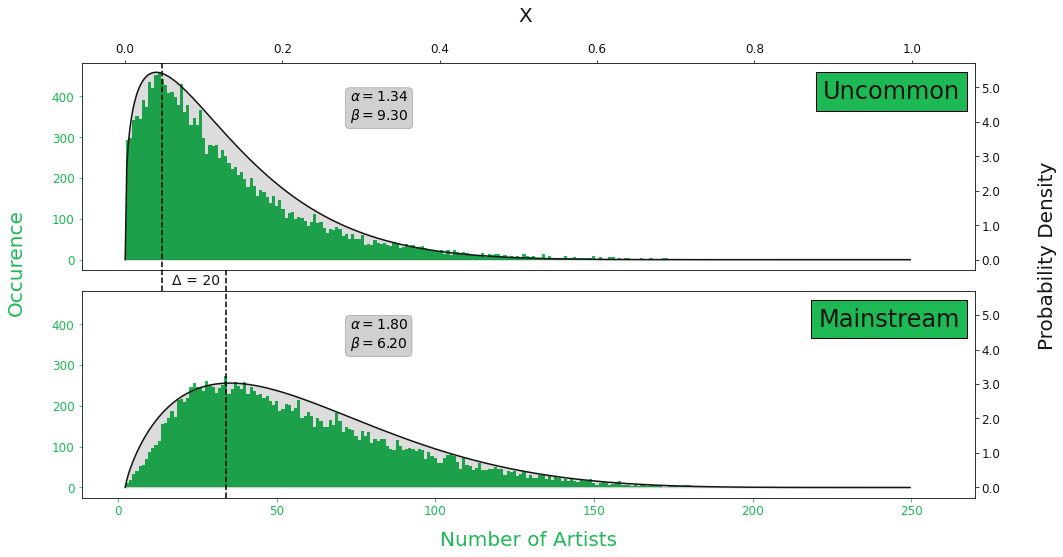

In [121]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211, frame_on=False)
ax3 = fig.add_subplot(212, sharex = ax1, sharey=ax1)
ax4 = fig.add_subplot(212, frame_on=False, sharex = ax2, sharey=ax2)

a_common = 1.8
b_common = 6.2

a_non_common = 1.34
b_non_common = 9.3

common_median = stats.mode(common_df['num_artists'])[0]
non_common_median = stats.mode(non_common_df['num_artists'])[0]


step_size = 0.002

x_beta_tracks, y_beta_tracks = calc_beta_pdf_values(a_common, b_common, step_size)
x_beta_artists, y_beta_artists = calc_beta_pdf_values(a_non_common, b_non_common, step_size)

draw_beta_dist(x_beta_tracks, y_beta_tracks, ax4, '#191414', x_pos='top', y_pos='right')
draw_nums(common_artists_nums.index, common_artists_nums.values, ax3, '#1DB954')

textstr_tracks = '\n'.join((r'$\alpha=%.2f$' % (a_common, ), r'$\beta=%.2f$' % (b_common, )))
add_info_box(ax3, textstr_tracks, 0.3, 0.87)

draw_beta_dist(x_beta_artists, y_beta_artists, ax2, '#191414', x_pos='top', y_pos='right')
draw_nums(non_common_artists_nums.index, non_common_artists_nums.values, ax1, '#1DB954')

textstr_artists = '\n'.join((r'$\alpha=%.2f$' % (a_non_common, ), r'$\beta=%.2f$' % (b_non_common, )))
add_info_box(ax1, textstr_artists, 0.3, 0.87)

ax1.axvline(non_common_median, ymin=-0.1, ymax=1, clip_on=False, color='black', linestyle='--')
ax3.axvline(common_median, ymin=0, ymax=1.1, clip_on=False, color='black', linestyle='--')

align.yaxes(ax1, 0, ax2, 0, pos=0.05)
align.xaxes(ax1, 0, ax2, 0, pos=0.05)
ax1.set_xlim([None, 270])
ax2.set_xlim([None, 1.08])

ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

ax1.tick_params(bottom = False)
ax4.tick_params(top = False)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)

ax2.text(0.5, 6.9, 'X', size=20, color='#191414')
ax2.text(-0.15,-1.5,'Occurence', size=20, rotation=90, color='#1DB954')
ax2.text(0.4,-8.3,'Number of Artists', size=20, color='#1DB954')
ax2.text(1.16,-2.5,'Probability Density', size=20, rotation=90, color='#191414')

mode_delta = abs(common_median[0] - non_common_median[0])

ax2.text(0.06, -0.715, f'\u0394 = {mode_delta}', size=14, color='#191414')

props = dict(boxstyle='square', facecolor='#1DB954')
ax3.text(0.825, 0.92, 'Mainstream', fontsize=24, transform=ax3.transAxes, verticalalignment='top', bbox=props, color='#191414')
ax1.text(0.83, 0.92, 'Uncommon', fontsize=24, transform=ax1.transAxes, verticalalignment='top', bbox=props, color='#191414')

plt.subplots_adjust(hspace=0.1)
#plt.show()
plt.savefig('pop_unpop_artist.pdf', bbox_inches="tight")

In [125]:
common_median

array([34])

In [64]:
playlist_df['description_binary'] = playlist_df['description'].map({float('nan'):0}).fillna(1)

In [65]:
playlist_df[playlist_df['num_followers'] >= 3]

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description,in_common,name_len,description_binary
20,mixtape,False,20,1509494400,14,9,3,11,2165531,6,NaN,1,7,0.0
28,Yeet,False,28,1509062400,81,57,7,26,18831207,37,NaN,9,4,0.0
40,2020,False,40,1490659200,85,80,6,27,18672695,71,NaN,4,4,0.0
44,taylor swift,False,44,1430611200,33,29,3,18,6837317,21,NaN,0,12,0.0
52,Christmas,False,52,1508976000,15,14,5,2,2647155,10,NaN,0,9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99965,#swole,False,99965,1444176000,72,58,3,8,16298922,39,NaN,3,6,0.0
99969,Best Songs of All Time,False,99969,1505865600,109,104,3,27,26246140,89,A collection of the greatest songs ever produc...,2,22,1.0
99979,summer 2015,False,99979,1480982400,82,67,5,44,16781394,63,NaN,0,11,0.0
99980,FM,False,99980,1447027200,191,160,3,7,45378204,107,NaN,0,2,0.0


In [66]:
description = playlist_df.groupby('num_followers').sum()['description_binary'].values
followers_size = playlist_df.groupby('num_followers').size().values
followers = playlist_df.groupby('num_followers').size().index
num_edits = playlist_df.groupby('num_followers').sum()['num_edits']

In [67]:
descrip_follow_df = pd.DataFrame([followers_size, description]).T
descrip_follow_df = descrip_follow_df.rename(columns={0: 'followers_cum', 1: 'description'})
descrip_follow_df['followers'] = followers
descrip_follow_df['num_edits'] = num_edits.values

In [68]:
descrip_follow_df['mask'] = descrip_follow_df['followers'] > 10
new_row = descrip_follow_df[descrip_follow_df['mask'] == True].groupby('mask').sum().reset_index().drop(columns=['mask'])
new_row['followers'] = 11

In [69]:
descrip_follow_df = descrip_follow_df[descrip_follow_df['mask'] == False].drop(columns=['mask'])

In [70]:
descrip_follow_df = descrip_follow_df.append(new_row)
descrip_follow_df = descrip_follow_df.set_index('followers')

In [71]:
descrip_follow_df['rel_descr'] = descrip_follow_df['description']/descrip_follow_df['followers_cum']
descrip_follow_df['rel_edits'] = descrip_follow_df['num_edits']/descrip_follow_df['followers_cum']

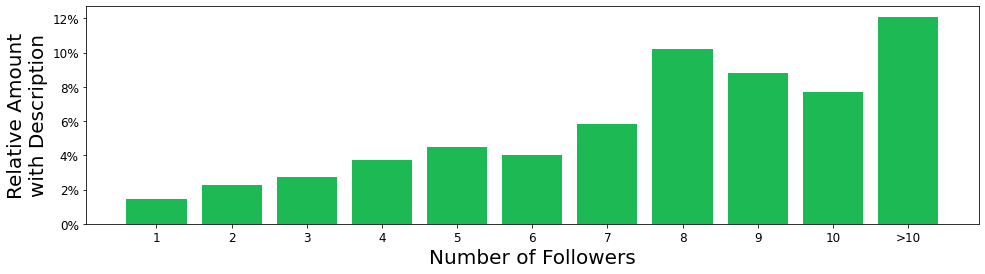

In [122]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.bar(descrip_follow_df.index, descrip_follow_df['rel_descr']*100, color='#1DB954')

xticks = descrip_follow_df.index.astype(str).to_list()
xticks[10] = '>10'
plt.xticks(range(1, len(xticks)+1), xticks)

ax.set_xlabel('Number of Followers', size=20)
ax.set_ylabel('Relative Amount\nwith Description', size=20)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

plt.savefig('followers_to_description.pdf', bbox_inches="tight")

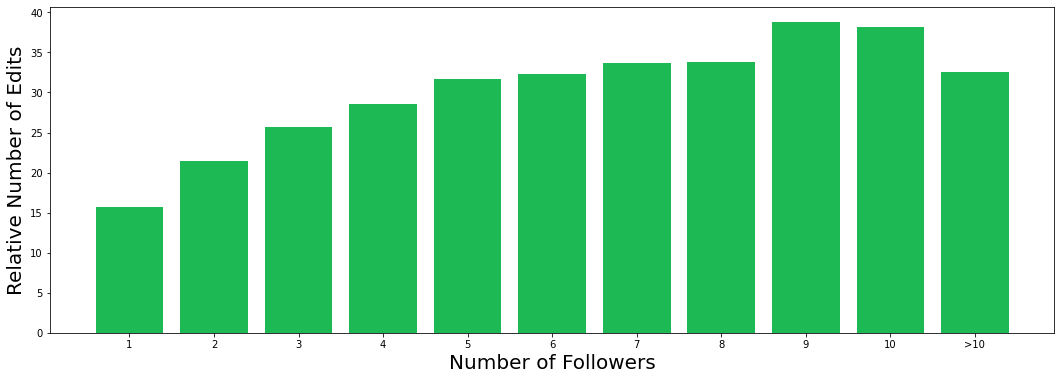

In [95]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.bar(descrip_follow_df.index, descrip_follow_df['rel_edits'], color='#1DB954')

xticks = descrip_follow_df.index.astype(str).to_list()
xticks[10] = '>10'
plt.xticks(range(1, len(xticks)+1), xticks)

ax.set_xlabel('Number of Followers', size=20)
ax.set_ylabel('Relative Number of Edits', size=20)

plt.show()